<a href="https://colab.research.google.com/github/SonOf1998/COVID-19_detection_in_lungs/blob/main/COVIDDetector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Mon Dec  7 13:12:10 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Installing packages


We'll use a model (SE-ResNet152) which is not a part of the Keras Application module.  
So in order to so a package needs to be installed beforehand.

The short documentation and available models:  
https://github.com/qubvel/classification_models

For the optimizer we will use AdaBound, which mixes the advantages of Adam and SGD and produces good results for our model.

AdaBound implementation for Keras:
https://github.com/Luolc/AdaBound

AdaBound paper:
https://openreview.net/forum?id=Bkg3g2R9FX

In [2]:
!pip install git+https://github.com/qubvel/classification_models.git
!pip install keras-adabound

  Cloning https://github.com/qubvel/classification_models.git to /tmp/pip-req-build-ts450pww
  Running command git clone -q https://github.com/qubvel/classification_models.git /tmp/pip-req-build-ts450pww
  Running command git submodule update --init --recursive -q
     |████████████████████████████████| 51kB 4.5MB/s 
  Created wheel for image-classifiers: filename=image_classifiers-1.0.0-cp36-none-any.whl size=20032 sha256=d4ef37aaa70f941f49e32c2fa67bf29a536779133e3f06d9372ed1d88e99f123
  Stored in directory: /tmp/pip-ephem-wheel-cache-rn5rtffc/wheels/de/2b/fd/29a6d33edb8c28bc7d94e95ea1d39c9a218ac500a3cfb1b197
Successfully built image-classifiers


# Download datasets from Github repository
Our repository: https://github.com/SonOf1998/COVID-19_detection_in_lungs

We download the content of our repository which contains the datasets we collected and cleaned beforehand.

In [4]:
import os
from urllib.request import urlretrieve
import requests
import zipfile
import shutil
import random

In [5]:
working_dir = os.getcwd()
local_zip = os.path.join(working_dir, 'main.zip')

In [6]:
url = 'https://github.com/SonOf1998/COVID-19_detection_in_lungs/archive/main.zip'
urlretrieve(url,local_zip) # Load content of repository into a local zip file

# Extract zip file
zip_ref = zipfile.ZipFile(local_zip,'r') 
zip_ref.extractall()
zip_ref.close()

# Discard zip file
if os.path.exists(local_zip):
  os.remove(local_zip)

In [7]:
repo_root_dir = os.path.join(working_dir, 'COVID-19_detection_in_lungs-main')   # Path to the downloaded directory

# Remove unnecessary files
if os.path.exists(os.path.join(repo_root_dir, 'COVIDDetector.ipynb')):
  os.remove(os.path.join(repo_root_dir, 'COVIDDetector.ipynb'))
if os.path.exists(os.path.join(repo_root_dir, 'LICENSE')):
  os.remove(os.path.join(repo_root_dir, 'LICENSE'))
if os.path.exists(os.path.join(repo_root_dir, 'README.md')):
  os.remove(os.path.join(repo_root_dir, 'README.md'))

In [8]:
# Move dataset directory to working directory
source = os.path.join(repo_root_dir, 'image_datasets')
shutil.move(source, working_dir)

# Remove repository root directory
os.rmdir(repo_root_dir)

We print out the number of train and test images to check how much data we have.

In [9]:
# Path to the moved dataset directory
datasets_dir = os.path.join(working_dir, 'image_datasets')

train_images_dir = os.path.join(datasets_dir, 'train_image_dataset')
test_images_dir = os.path.join(datasets_dir, 'test_image_dataset')

train_covid_images_dir = os.path.join(train_images_dir, 'covid_19')
train_no_findings_images_dir = os.path.join(train_images_dir, 'no_findings')
train_pneumonia_images_dir = os.path.join(train_images_dir, 'pneumonia')

test_covid_images_dir = os.path.join(test_images_dir, 'covid_19')
test_no_findings_images_dir = os.path.join(test_images_dir, 'no_findings')
test_pneumonia_images_dir = os.path.join(test_images_dir, 'pneumonia')

print('train images: {}'.format(len(os.listdir(train_covid_images_dir))+len(os.listdir(train_no_findings_images_dir))+len(os.listdir(train_pneumonia_images_dir))))
print('train covid images: {}'.format(len(os.listdir(train_covid_images_dir))))
print('train no findings images: {}'.format(len(os.listdir(train_no_findings_images_dir))))
print('train pneumonia images: {}'.format(len(os.listdir(train_pneumonia_images_dir))))

print('test images: {}'.format(len(os.listdir(test_covid_images_dir))+len(os.listdir(test_no_findings_images_dir))+len(os.listdir(test_pneumonia_images_dir))))
print('test covid images: {}'.format(len(os.listdir(test_covid_images_dir))))
print('test no findings images: {}'.format(len(os.listdir(test_no_findings_images_dir))))
print('test pneumonia images: {}'.format(len(os.listdir(test_pneumonia_images_dir))))

train images: 1269
train covid images: 370
train no findings images: 449
train pneumonia images: 450
test images: 137
test covid images: 37
test no findings images: 50
test pneumonia images: 50


# Preparing datasets
We are going to use ImageDataGenerators to load images directly from the train and test directories while doing augmentation on the training set simultaneously.

In [10]:
img_height = 256    # Input image height
img_width = 256     # Input image width
batch_size = 32
class_mode = 'categorical'  # 3 categories: covid_19, pneumonia, no_findings
color_mode = 'rgb'  # SE-ResNet needs all 3 channels

## Data augmentation and splitting data into train, validation and test batches
In order to create more training data we allow the corresponding ImageDataGenerator to generate new instances by slightly rotating and zooming the original images. We also enable horizontal flipping and large scaled adjustments on brightness because it's reasonable to do so while working with data like that.

Also, we set the preprocessing function to the one SE-ResNet152 uses in the industry.

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from classification_models.keras import Classifiers

SEResNet152, preprocess_input = Classifiers.get('seresnet152')

# 20% validation split of train datasets
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, 
                                  validation_split=0.2, rotation_range=5, 
                                  zoom_range=0.075, brightness_range=[0.8, 1.2], 
                                  horizontal_flip=True)

# generate training batches from train directory 
train_iter = train_datagen.flow_from_directory(
    train_images_dir,
    target_size=(img_height, img_width),
    batch_size = batch_size,
    class_mode = class_mode,
    color_mode = color_mode,
    seed = 42,
    shuffle = True,
    subset='training'
)

# generate validation batches from train directory
validation_iter = train_datagen.flow_from_directory(
    train_images_dir,
    target_size=(img_height, img_width),
    batch_size = batch_size,
    class_mode = class_mode,
    color_mode = color_mode,
    shuffle = False,
    subset='validation'
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# generate test batches from test directory
test_iter = test_datagen.flow_from_directory(
    test_images_dir,
    target_size=(img_height, img_width),
    batch_size = 1,
    class_mode = class_mode,
    color_mode = color_mode,
    shuffle = False
)

Found 1016 images belonging to 3 classes.
Found 253 images belonging to 3 classes.
Found 137 images belonging to 3 classes.


# Data visualization
We visualize an augmented and preprocessed batch of data.

In [12]:
import numpy as np

iter = train_iter.next()    # Get the first batch of preprocessed images
xrays = iter[0]
labels = iter[1]  # One-hot encoding: 
                  # [1, 0, 0] - covid_19, 
                  # [0, 1, 0] - no_findings, 
                  # [0, 0, 1] - pneumonia

In [13]:
train_iter.class_indices

{'covid_19': 0, 'no_findings': 1, 'pneumonia': 2}

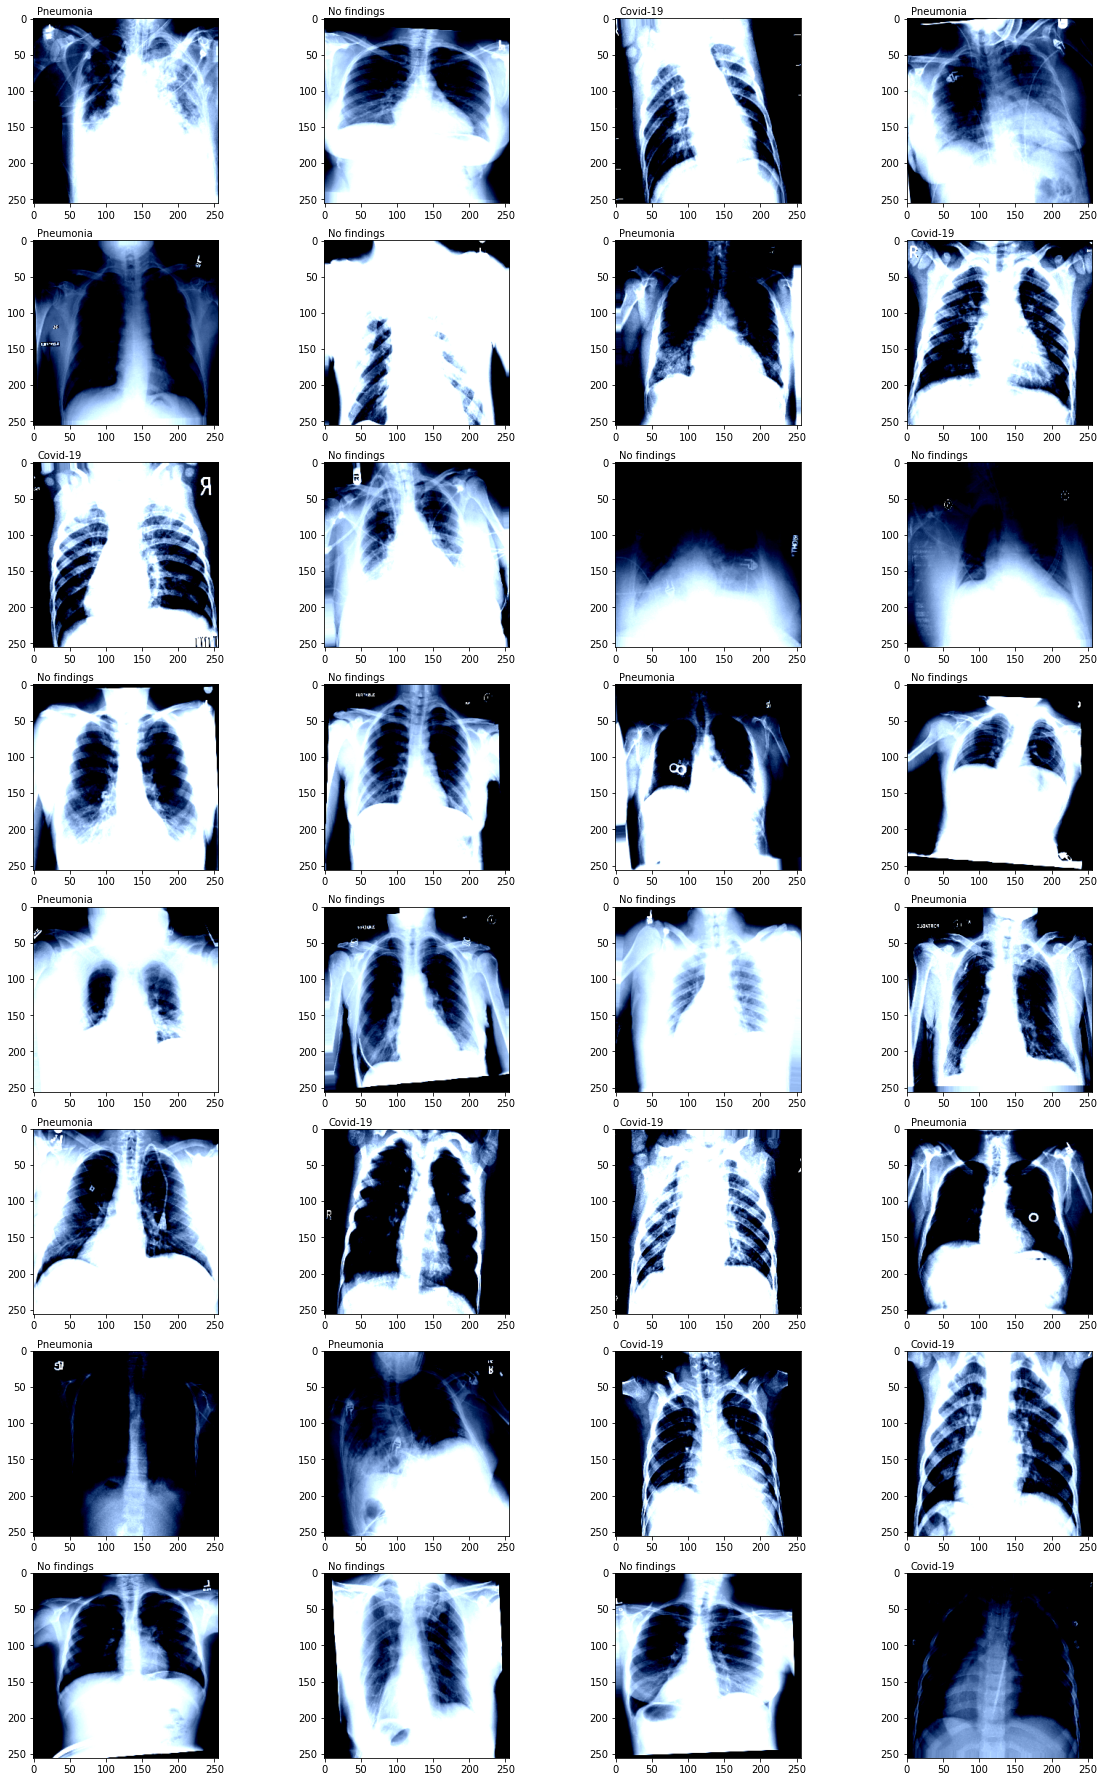

In [14]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

ncols = 4 # Preferred amount of columns
nrows = int(np.ceil(xrays.shape[0]/ncols)) # Calculate num of rows based on batch size

fig = plt.gcf()
fig.set_size_inches(ncols * 5, nrows * 4)

# Plot
for i, img in enumerate(xrays):
  sp = plt.subplot(nrows, ncols, i + 1)
  plt.imshow(np.clip(img, 0, 1))
  if(labels[i][0] == 1):
    plt.text(x = 5, y = -5, s='Covid-19')
  elif(labels[i][1] == 1):
    plt.text(x = 5, y = -5, s='No findings')
  elif(labels[i][2] == 1):
    plt.text(x = 5, y = -5, s='Pneumonia')
plt.show()

In [15]:
# Reset the iterator
train_iter.reset()
train_iter.total_batches_seen = 0

# Creating the model

We initialize our network by attaching a custom neural network to the lower parts of the SE-ResNet152 model.

We use softmax activation as we'd like to classify between 3 classes.

In [16]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras import Input, Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from keras_adabound import AdaBound

In [17]:
base_model = SEResNet152(
include_top=False,
weights="imagenet",
input_tensor=None,
input_shape=(256, 256, 3),
classes=3,
)

dense_model = Sequential([
    GlobalAveragePooling2D(),
    Dense(3256, activation='relu'),
    Dropout(0.3),
    Dense(1576, activation='relu'),
    Dense(2080, activation='relu'),
    Dropout(0.2),
    Dense(2752, activation='relu'),
    Dense(904, activation='relu'),
    Dropout(0.2),
    Dense(3, activation='softmax')
])
model = Model(inputs=[base_model.input], outputs=[dense_model(base_model.output)])

261390336/261385016 [==============================] - 7s 0us/step


# Training

We allow every part of our model to train.

Defining an EarlyStopping and ModelCheckpoint can help cancelling the stuck learning process and restoring the best model we got so far.

In [18]:
checkpoint = ModelCheckpoint("best_model_weights.cp", save_weights_only=True, save_best_only=True, monitor="val_accuracy", verbose=1)
early_stop = EarlyStopping(monitor="val_accuracy", patience=8)

In [ ]:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)


Experimentation shows that teaching the whole model from the start provides the best results.

Due of the lack of resources we only enable the training of 698 layers out of 914 in the SE-ResNet152 model.

In [20]:
split = 216
for layer in base_model.layers[:split]:
    layer.trainable = False
for layer in base_model.layers[split:]:
    layer.trainable = True

In [21]:
optimizer = AdaBound()

model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

model.fit(
    train_iter,
    epochs=10000,
    validation_data=validation_iter,
    callbacks=[checkpoint, early_stop]
)

Epoch 1/10000
32/32 [==============================] - ETA: 0s - loss: 1.2195 - accuracy: 0.4419
Epoch 00001: val_accuracy improved from -inf to 0.35573, saving model to best_model_weights.cp
32/32 [==============================] - 57s 2s/step - loss: 1.2195 - accuracy: 0.4419 - val_loss: 126778156777472.0000 - val_accuracy: 0.3557
Epoch 2/10000
32/32 [==============================] - ETA: 0s - loss: 0.7740 - accuracy: 0.6220
Epoch 00002: val_accuracy did not improve from 0.35573
32/32 [==============================] - 48s 1s/step - loss: 0.7740 - accuracy: 0.6220 - val_loss: 229783.1406 - val_accuracy: 0.3518
Epoch 3/10000
32/32 [==============================] - ETA: 0s - loss: 0.5707 - accuracy: 0.7165
Epoch 00003: val_accuracy improved from 0.35573 to 0.47036, saving model to best_model_weights.cp
32/32 [==============================] - 52s 2s/step - loss: 0.5707 - accuracy: 0.7165 - val_loss: 390.1595 - val_accuracy: 0.4704
Epoch 4/10000
32/32 [==============================] 

# Evaluation
We make a quick evaluation by measuring the accuracy of the model on the test set and displaying the confusion matrix.

In [22]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn

In [23]:
model.load_weights("best_model_weights.cp")

loss, acc = model.evaluate(test_iter)
acc

137/137 [==============================] - 4s 31ms/step - loss: 0.4031 - accuracy: 0.8394


0.8394160866737366

Classification Report
              precision    recall  f1-score   support

    covid_19       0.97      0.92      0.94        37
 no_findings       0.85      0.78      0.81        50
   pneumonia       0.75      0.84      0.79        50

    accuracy                           0.84       137
   macro avg       0.86      0.85      0.85       137
weighted avg       0.85      0.84      0.84       137

Confusion Matrix


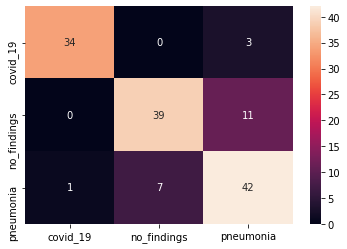

In [24]:
Y_pred = model.predict(test_iter)
y_pred = np.argmax(Y_pred, axis=1)
print('Classification Report')
target_names = ['covid_19', 'no_findings', 'pneumonia']
print(classification_report(test_iter.classes, y_pred, target_names=target_names))
print('Confusion Matrix')
sn.heatmap(confusion_matrix(test_iter.classes, y_pred), annot=True, xticklabels=target_names, yticklabels=target_names)